In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

In [74]:
# Read the dataset (assuming it is whitespace-delimited)
df = pd.read_csv("salary.txt", delim_whitespace=True)
df.head()

/var/folders/46/1g8dfqwd0rv1l3j1b2xcjy2r0000gn/T/ipykernel_15413/614975239.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv("salary.txt", delim_whitespace=True)


,case,id,sex,deg,yrdeg,field,startyr,year,rank,admin,salary
0,1,1,F,Other,92,Other,95,95,Assist,0,6684.0
1,2,2,M,Other,91,Other,94,94,Assist,0,4743.0
2,3,2,M,Other,91,Other,94,95,Assist,0,4881.0
3,4,4,M,PhD,96,Other,95,95,Assist,0,4231.0
4,5,6,M,PhD,66,Other,91,91,Full,1,11182.0


In [75]:
# Display the columns to confirm variable names
print("Columns in dataset:", df.columns.tolist())

Columns in dataset: ['case', 'id', 'sex', 'deg', 'yrdeg', 'field', 'startyr', 'year', 'rank', 'admin', 'salary']


In [76]:
# Subset the data to include only the records for the years 1990 and 1995
df_sub = df[df['year'].isin([90, 95])]

In [77]:
# Pivot the data so each faculty member (id) has salary for each year as separate columns
df_wide = df_sub.pivot(index='id', columns='year', values='salary').reset_index()
df_wide.head()

year,id,90,95
0,1,NaN,6684.0
1,2,NaN,4881.0
2,4,NaN,4231.0
3,6,NaN,12184.0
4,7,3814.0,4604.0


In [78]:
# Merge in constant faculty attributes from the 1995 records (e.g., sex, rank, field, yrdeg, deg, startyr)
df_1995 = df[df['year'] == 95][['id', 'sex', 'rank', 'field', 'yrdeg', 'deg', 'startyr']].drop_duplicates(subset='id')
df_model = pd.merge(df_wide, df_1995, on='id', how='left')

In [79]:
df_model.head()

,id,90,95,sex,rank,field,yrdeg,deg,startyr
0,1,NaN,6684.0,F,Assist,Other,92,Other,95
1,2,NaN,4881.0,M,Assist,Other,91,Other,94
2,4,NaN,4231.0,M,Assist,Other,96,PhD,95
3,6,NaN,12184.0,M,Full,Other,66,PhD,91
4,7,3814.0,4604.0,M,Assoc,Other,70,PhD,71


In [80]:
# Keep only those individuals who have salary data for both 1990 and 1995
df_model = df_model.dropna(subset=[90, 95])

In [81]:
# Compute the salary increase for each faculty member
df_model['salary_increase'] = df_model[95] - df_model[90]

In [ ]:
# Compute "experience" as the number of years from startyr to 1995
df_model['experience'] = 95 - df_model['startyr']

In [83]:
df_model.head()

,id,90,95,sex,rank,field,yrdeg,deg,startyr,salary_increase,experience
4,7,3814.0,4604.0,M,Assoc,Other,70,PhD,71,790.0,1924
6,9,4800.0,5472.0,M,Assoc,Other,82,PhD,87,672.0,1908
7,10,6120.0,7494.0,M,Full,Arts,68,PhD,80,1374.0,1915
8,12,8145.0,9286.0,M,Full,Other,64,PhD,64,1141.0,1931
9,13,7475.0,8770.0,M,Full,Prof,68,PhD,69,1295.0,1926


In [84]:
print("Summary of salary increase by sex:")
print(df_model.groupby('sex')['salary_increase'].describe())

Summary of salary increase by sex:
     count         mean         std      min    25%     50%     75%     max
sex                                                                        
F    267.0  1164.104558  622.310688  281.000  730.0   997.0  1418.5  4822.0
M    963.0  1241.471747  647.915578   69.333  819.0  1101.0  1504.5  6844.0


# ---------------------------
# 1. Two-Sample t-Test
# ---------------------------

In [85]:
male_increase = df_model[df_model['sex'] == 'M']['salary_increase']
female_increase = df_model[df_model['sex'] == 'F']['salary_increase']

t_stat, p_val = stats.ttest_ind(male_increase, female_increase, equal_var=False)
print("\nTwo-sample t-test comparing salary increases by sex:")
print("t-statistic =", t_stat, "p-value =", p_val)


Two-sample t-test comparing salary increases by sex:
t-statistic = 1.7813233036313076 p-value = 0.07555099492574219


**Mean Salary Increase:** Men’s average increase is about $1,241, while women’s is about $1,164—a difference of roughly $77 in favor of men.

**Two-Sample t-Test (p-value = 0.0755):** Because the p-value is slightly above the conventional 0.05 threshold, we do not have sufficient statistical evidence at the 5% significance level to conclude that this difference is statistically significant.
In practical terms, although men show a somewhat higher mean salary increase, the t-test suggests that this difference could plausibly be due to chance variation. One might say the difference is “marginally non-significant” or “suggestive” but not strong enough (by usual criteria) to claim a statistically significant gap.

# ---------------------------
# 2. Multiple Regression with Interactions
# ---------------------------

In [86]:
# Model: salary_increase ~ sex + experience + rank + field + yrdeg + (sex x rank) + (sex x field)
model_formula = ("salary_increase ~ C(sex) + experience + C(rank) + C(field) + yrdeg + "
                 "C(sex):C(rank) + C(sex):C(field)")
reg_model = smf.ols(formula=model_formula, data=df_model).fit()
print("\nMultiple Regression Summary:")
print(reg_model.summary())


Multiple Regression Summary:
                            OLS Regression Results                            
Dep. Variable:        salary_increase   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     24.40
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           6.59e-46
Time:                        14:59:33   Log-Likelihood:                -9575.7
No. Observations:                1230   AIC:                         1.918e+04
Df Residuals:                    1218   BIC:                         1.924e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

**Overall Model Fit**
R-squared = 0.181: About 18% of the variation in salary increase is explained by these predictors.

F-statistic (24.40) with p < 0.0001: The overall model is statistically significant.

## Individual Coefficients and Significance

1. sex[T.M] (coefficient = 38.05, p = 0.828)

    - Once rank, field, experience, and year of degree are controlled for, there is no significant difference in salary increase between male and female faculty (p ≈ 0.828 is far above 0.05).
    - In other words, being male instead of female is associated with an increase of about $38, but that estimate is not statistically distinguishable from zero.

2. rank[T.Assoc] (475.18, p < 0.001) and rank[T.Full] (1072.09, p < 0.001)

    - Both are strongly significant. Compared to Assistant rank, Associate Professors have on average about $475 higher salary increases; Full Professors about $1072 higher.
    - This suggests rank is a major driver of salary growth over this period.

3. field[T.Other] (−23.81, p = 0.787) and field[T.Prof] (38.89, p = 0.772)

    - Neither differs significantly from the baseline field (likely “Arts”). Field does not appear to be a strong factor in explaining differences in salary increases.

4. Interactions with Sex

    - C(sex)[T.M]:C(rank)[T.Assoc], C(sex)[T.M]:C(rank)[T.Full], C(sex)[T.M]:C(field)[T.Other], C(sex)[T.M]:C(field)[T.Prof] all have p > 0.05.
    - No evidence that the effect of rank or field on salary increase depends on being male or female.

5. experience (−4.78, p = 0.121)

    - Not significant. Each additional year of experience is associated with a slight (non-significant) drop in salary increase. The large p-value suggests this effect is not reliable.

6. yrdeg (18.10, p < 0.0001)

    - Highly significant. Each additional year in the highest degree year is associated with about $18 more in salary increase.
    - This implies more recent graduates (larger yrdeg) saw somewhat faster salary growth between 1990 and 1995, controlling for the other factors.

## Interpretation
1. Sex is Not a Significant Predictor

    - After adjusting for rank, field, experience, and year of degree, men and women do not differ significantly in how their salaries grew from 1990 to 1995.

2. Rank Matters Substantially

    - Being at Associate or Full rank is associated with a higher salary increase than the Assistant rank, with Full Professors seeing the largest jump.

3. Year of Degree Matters

    - More recent degrees are linked to bigger salary increases, possibly indicating that newer hires are “catching up” or seeing more rapid salary growth.

4. No Significant Interactions by Sex

    - The model finds no evidence that the impact of rank or field on salary increase is different for men and women.

In [87]:
# Model: salary_increase ~ sex
model_formula = ("salary_increase ~ C(sex)")
reg_model_sex = smf.ols(formula=model_formula, data=df_model).fit()
print("\nLinear Regression Summary:")
print(reg_model_sex.summary())


Linear Regression Summary:
                            OLS Regression Results                            
Dep. Variable:        salary_increase   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.032
Date:                Mon, 10 Mar 2025   Prob (F-statistic):             0.0819
Time:                        14:59:50   Log-Likelihood:                -9696.6
No. Observations:                1230   AIC:                         1.940e+04
Df Residuals:                    1228   BIC:                         1.941e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1164.1046

# ---------------------------
# 3. One-Way ANOVA by Sex
# ---------------------------

In [70]:
# Optionally, run separate one-way ANOVAs for each sex
print("\nOne-way ANOVA by graduation group, separated by sex:")
for s in df_model['sex'].unique():
    group_data = df_model[df_model['sex'] == s]
    # Collect salary increase data for each graduation group
    groups = [group_data[group_data['grad_group'] == grp]['salary_increase'] 
              for grp in group_data['grad_group'].unique()]
    if len(groups) > 1:
        f_stat, p_value = stats.f_oneway(*groups)
        print(f"Sex = {s}: F-statistic = {f_stat:.3f}, p-value = {p_value:.3f}")
    else:
        print(f"Sex = {s}: Not enough groups for ANOVA.")


One-way ANOVA by graduation group, separated by sex:
Sex = M: F-statistic = 6.920, p-value = 0.000
Sex = F: F-statistic = 2.985, p-value = 0.032


/var/folders/46/1g8dfqwd0rv1l3j1b2xcjy2r0000gn/T/ipykernel_15413/769679489.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sex', y='salary_increase', data=df_wide, palette='Set2')


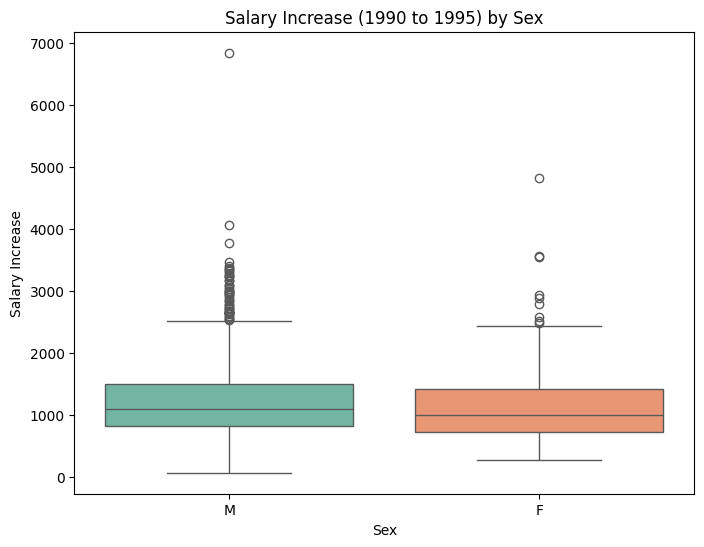

In [ ]:
# 1. Boxplot of salary increase by sex
plt.figure(figsize=(8,6))
sns.boxplot(x='sex', y='salary_increase', data=df_wide, palette='Set2')
plt.title("Salary Increase (1990 to 1995) by Sex")
plt.xlabel("Sex")
plt.ylabel("Salary Increase")
plt.show()

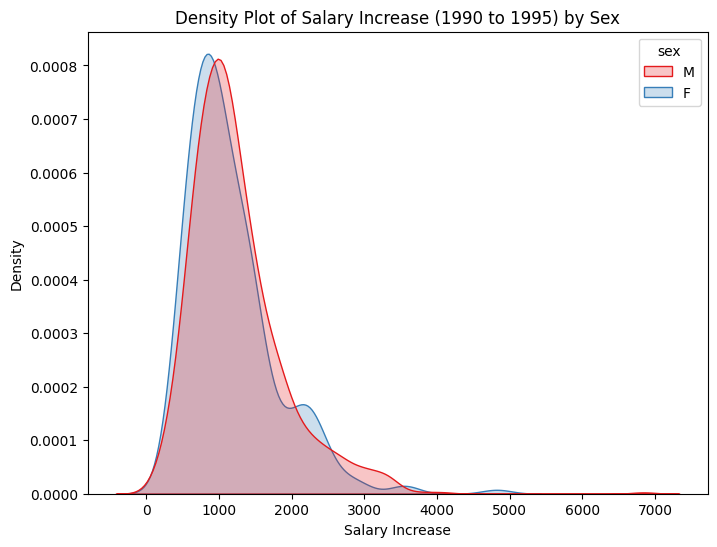

In [24]:
# 2. Density plot of salary increase by sex
plt.figure(figsize=(8,6))
sns.kdeplot(data=df_wide, x='salary_increase', hue='sex', fill=True, common_norm=False, palette='Set1')
plt.title("Density Plot of Salary Increase (1990 to 1995) by Sex")
plt.xlabel("Salary Increase")
plt.ylabel("Density")
plt.show()

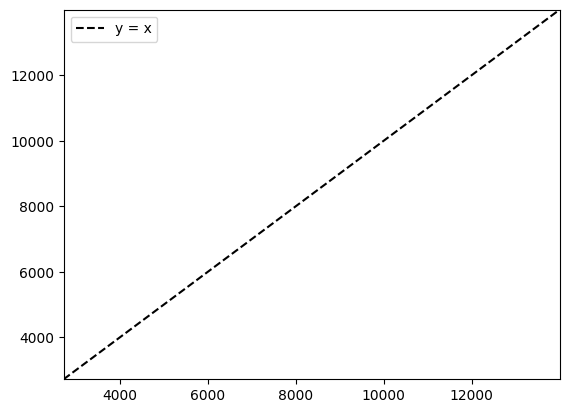

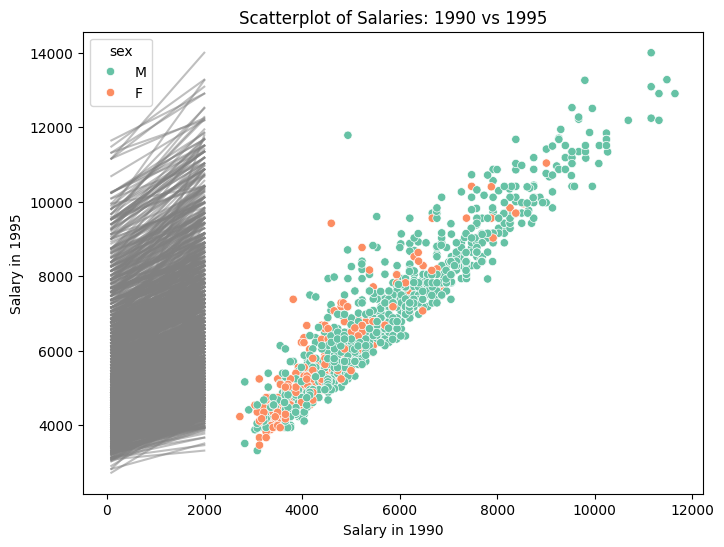

In [ ]:

# 3. Scatterplot: salary in 1990 vs. salary in 1995 with individual trajectories
min_salary = min(df_model[90].min(), df_model[95].min())
max_salary = max(df_model[90].max(), df_model[95].max())
plt.xlim(min_salary, max_salary)
plt.ylim(min_salary, max_salary)
plt.plot([min_salary, max_salary], [min_salary, max_salary], 'k--', label='y = x')
plt.legend()
plt.figure(figsize=(8,6))
# Plot lines for each individual (light gray for visualizing trends)
for _, row in df_model.iterrows():
    plt.plot([90, 1995], [row[90], row[95]], color='gray', alpha=0.5)
# Overlay scatter points colored by sex
sns.scatterplot(x=90, y=95, hue='sex', data=df_model, palette='Set2')
plt.title("Scatterplot of Salaries: 1990 vs 1995")
plt.xlabel("Salary in 1990")
plt.ylabel("Salary in 1995")
plt.show()

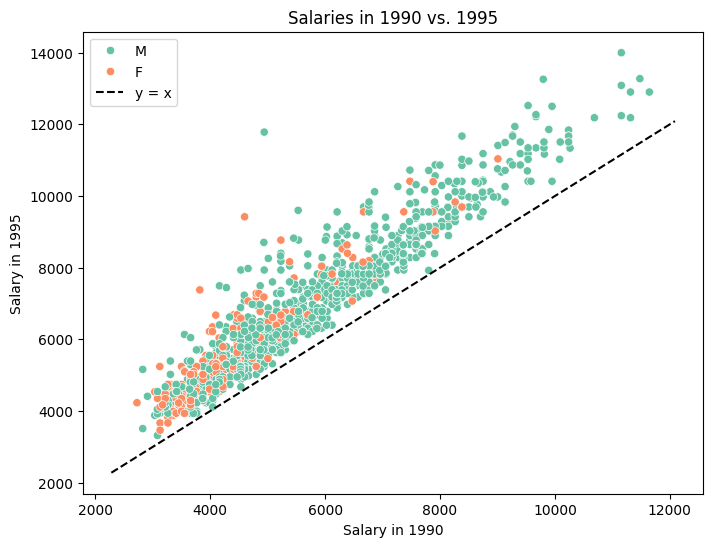

In [97]:
plt.figure(figsize=(8,6))

# Overlay scatter points colored by sex
sns.scatterplot(x=90, y=95, hue='sex', data=df_model, palette='Set2')

# Add a y=x reference line across the current x-axis limits
xmin, xmax = plt.xlim()
plt.plot([xmin, xmax], [xmin, xmax], 'k--', label='y = x')

plt.title("Salaries in 1990 vs. 1995")
plt.xlabel("Salary in 1990")
plt.ylabel("Salary in 1995")
plt.legend()
plt.show()